In [4]:
import cv2 as cv
import numpy as np
from utils import *
import matplotlib.pyplot as plt

### 读入图像与获取基本属性

In [5]:
lena = cv.imread('lena.jpg')
get_attributes(lena)  
# show_img('lena', lena)

Image shape: (512, 512, 3)
Image size: 786432
Image data type: uint8


(512, 512, 3)

### 彩色图像转换及灰度化

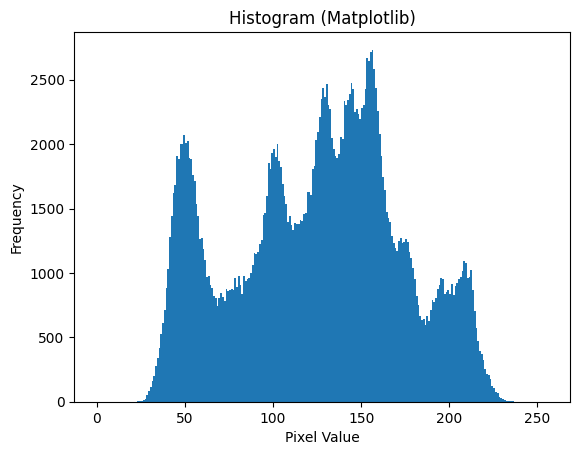

In [6]:
# 颜色空间转化 BGR -> HSV
lena_hsv = cv.cvtColor(lena, cv.COLOR_BGR2HSV)

# show_img('lena_hsv', lena_hsv)
# 灰度化
lena_gray = cv.cvtColor(lena, cv.COLOR_BGR2GRAY)

# 灰度直方图
plot_histogram(lena_gray, 3)

### 二值化处理

固定阈值分割

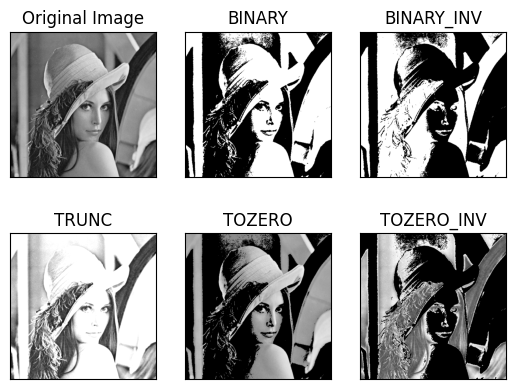

In [15]:
threshold = 127 # 阈值
th_fixed = visualize_threshold_methods(lena_gray, threshold)

自适应阈值分割

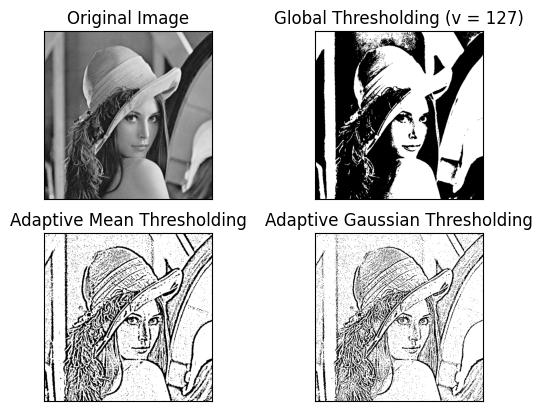

In [ ]:
th_adaptive_mean = cv.adaptiveThreshold(lena_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, 
                                   cv.THRESH_BINARY, 11, 5)
th_adaptive_gaussian = cv.adaptiveThreshold(lena_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY, 11, 5)
titles = ['Original Image', 'Global Thresholding (v = 127)', 
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [lena_gray, th_fixed, th_adaptive_mean, th_adaptive_gaussian]

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

Otsu's 自动计算阈值分割

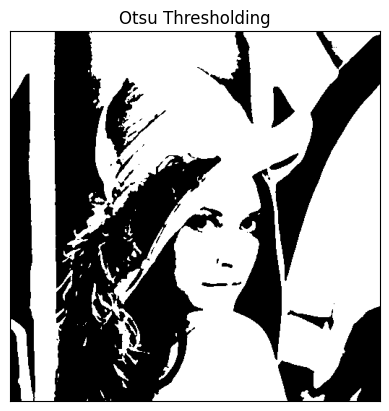

In [ ]:
th_otsu = cv.threshold(lena_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
plt.imshow(th_otsu, 'gray')
plt.title('Otsu Thresholding')
plt.xticks([]), plt.yticks([])
plt.show()

### 图像分割

区域生长

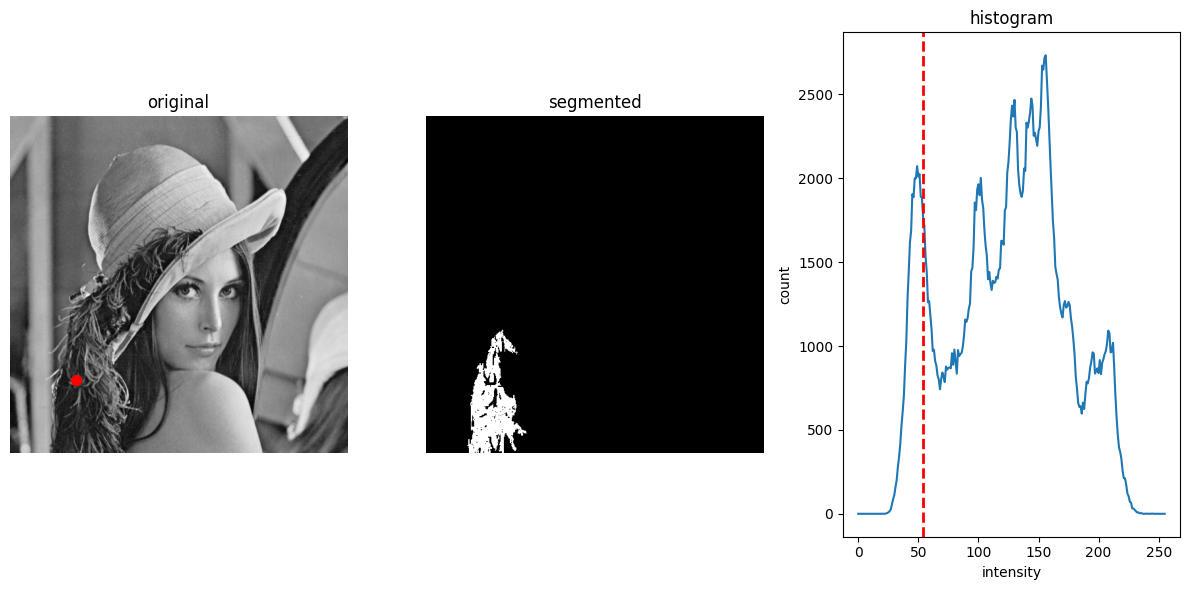

In [ ]:
# 区域生长
def region_growing(image, seed_point, threshold):
    """
    区域生长算法，基于给定的种子点和相似性阈值对图像进行分割。
    
    参数:
    - image: 输入的灰度图像（numpy数组）。
    - seed_point: 表示种子点坐标的元组 (x, y)。
    - threshold: 像素包含在区域内的相似性阈值。
    
    返回:
    - segmented_image: 分割后的图像，其中区域标记为255。
    """
    # 获取图像的尺寸
    rows, cols = image.shape
    
    # 创建一个掩膜以跟踪访问过的像素
    visited = np.zeros_like(image, dtype=bool)
    
    # 初始化分割图像为零
    segmented_image = np.zeros_like(image)
    
    # 使用栈进行洪水填充
    stack = [seed_point]
    
    # 标记种子点为已访问并属于区域的一部分
    visited[seed_point] = True
    segmented_image[seed_point] = 255
    
    while stack:
        current_point = stack.pop()
        
        # 获取当前点的强度
        current_intensity = image[current_point]
        
        # 定义邻居（4连通性：上、下、左、右）
        neighbors = [(current_point[0] + 1, current_point[1]),
                     (current_point[0] - 1, current_point[1]),
                     (current_point[0], current_point[1] + 1),
                     (current_point[0], current_point[1] - 1)]
        
        for neighbor in neighbors:
            x, y = neighbor
            
            # 检查邻居是否在边界内且未被访问过
            if 0 <= x < rows and 0 <= y < cols and not visited[x, y]:
                neighbor_intensity = image[x, y]
                
                # 检查邻居的强度是否在阈值范围内
                if abs(neighbor_intensity - current_intensity) <= threshold:
                    stack.append((x, y))
                    visited[x, y] = True
                    segmented_image[x, y] = 255
    
    return segmented_image

lena_gray_float = np.float32(lena_gray)

# 定义种子点和阈值
seed_point = (400, 100)  # 示例种子点
threshold = 8         # 相似性阈值

# 应用区域生长算法
segmented_image = region_growing(lena_gray_float, seed_point, threshold)

# 创建一个图形窗口来显示结果
plt.figure(figsize=(12, 6))

# 显示原始图像并在种子点处标记
plt.subplot(1, 3, 1)
plt.imshow(lena_gray, cmap='gray')
plt.title('original')
plt.scatter(seed_point[1], seed_point[0], c='red', s=50)  # 标记种子点
plt.axis('off')

# 显示分割后的图像
plt.subplot(1, 3, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('segmented')
plt.axis('off')

# 显示灰度直方图以帮助选择阈值
plt.subplot(1, 3, 3)
histogram, bins = np.histogram(lena_gray.ravel(), 256, [0, 256])
plt.plot(histogram)
plt.axvline(x=lena_gray[seed_point], color='r', linestyle='dashed', linewidth=2)
plt.title('histogram')
plt.xlabel('intensity')
plt.ylabel('count')

# 调整子图之间的间距
plt.tight_layout()

# 显示所有图像
plt.show()

### 空间域图像增强与频域滤波

#### 空间域

灰度直方图修正

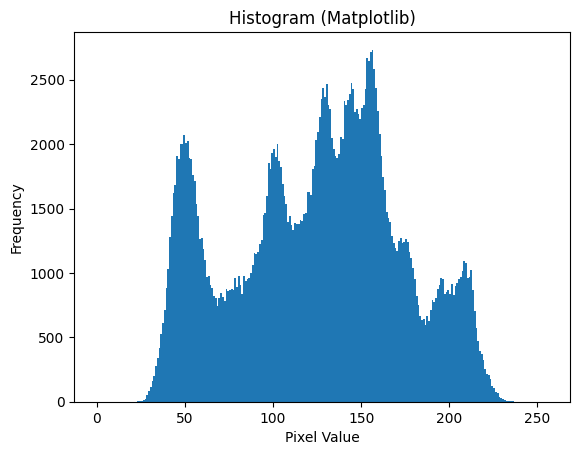

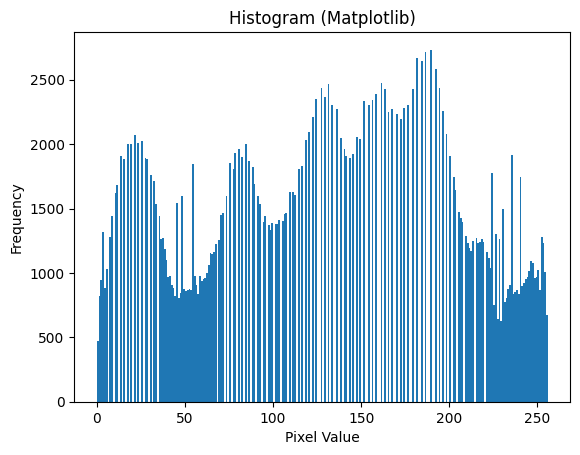

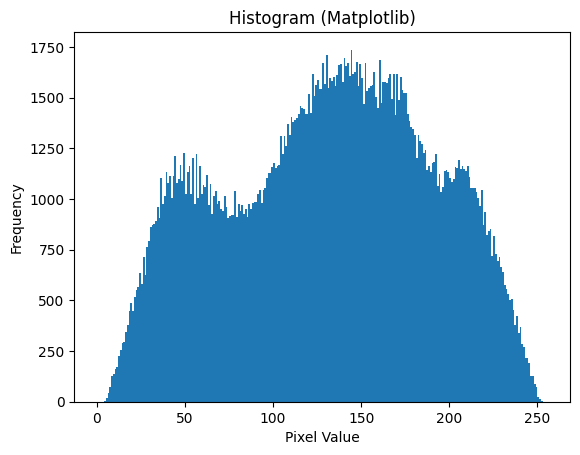

In [ ]:
# 直方图均衡化
lena_gray_equalize = cv.equalizeHist(lena_gray)
plot_histogram(lena_gray, 3)
plot_histogram(lena_gray_equalize, 3)
#lena_gray_equalize_hist = np.bincount(lena_gray_equalize.ravel(), minlength=256)

# 对比度限制自适应直方图均衡化
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # 创建clahe, 设置剪切阈值（clipLimit), 网格大小（tileGridSize）
lena_gray_clahe = clahe.apply(lena_gray)
plot_histogram(lena_gray_clahe, 3)
#show_img('Equalize and Clahe', np.hstack((lena_gray, lena_gray_equalize, lena_gray_clahe)))

线性变换
g(x,y)=a⋅f(x,y)+b

In [ ]:
# 定义线性变换参数
alpha = 1.5  # 对比度增益
beta = 15   # 亮度增益

lena_gray_linear = cv.convertScaleAbs(lena_gray, alpha=alpha, beta=beta)
#show_img('Linear Transform', np.hstack((lena_gray, lena_gray_linear)))

对数变换: 压缩高灰度值，扩展低灰度值，适合处理动态范围较大的图像

In [ ]:
# 对数变换
c = 1
lena_gray_log = c * np.log(1 + lena_gray).astype(np.uint8)

max_val = np.max(lena_gray_log) # 计算最大值以进行归一化
lena_gray_log = (lena_gray_log / max_val * 255).astype(np.uint8) # 归一化
#show_img('Log Transform', np.hstack((lena_gray, lena_gray_log)))

指数变换：

In [ ]:
# 指数变换
c = 1
gamma = 0.5
lena_gray_exp = c * np.power(lena_gray, gamma).astype(np.uint8)

max_val = np.max(lena_gray_exp) # 计算最大值以进行归一化
lena_gray_exp = (lena_gray_exp / max_val * 255).astype(np.uint8) # 归一化
#show_img('Exponential Transform', np.hstack((lena_gray, lena_gray_exp)))


均值滤波

In [21]:
lena_blurred_mean = cv.blur(lena, (5, 5))
#show_img('Mean Blur', np.hstack((lena, lena_blurred_mean)))

高斯滤波

In [ ]:
lena_blurred_gaussian = cv.GaussianBlur(lena, (5, 5), 0)
#show_img('Gaussian Blur', np.hstack((lena, lena_blurred_gaussian)))

中值滤波

In [ ]:
lena_blurred_median = cv.medianBlur(lena, 5)
#show_img('Median Blur', np.hstack((lena, lena_blurred_median)))

双边滤波

In [ ]:
lena_blurred_bilateral = cv.bilateralFilter(lena, 9, 75, 75)
#show_img('Bilateral Blur', np.hstack((lena, lena_blurred_bilateral)))

Sobel算子锐化

In [4]:
lena_blurred_gaussian = cv.GaussianBlur(lena, (5, 5), 0) # 高斯滤波，去噪
sobel_x = cv.Sobel(lena_blurred_gaussian, cv.CV_64F, 1, 0, ksize=3) # x方向sobel算子
sobel_y = cv.Sobel(lena_blurred_gaussian, cv.CV_64F, 0, 1, ksize=3) # y方向sobel算子
gradient_magnitude = cv.magnitude(sobel_x, sobel_y) # 梯度幅值
gradient_magnitude = np.uint8(255 * gradient_magnitude / np.max(gradient_magnitude)) # 归一化
lena_sobel = cv.addWeighted(lena, 1.5, gradient_magnitude, 0.5, 0) # 叠加
show_img('Sobel Filter', np.hstack((lena, lena_sobel)))

拉普拉斯算子锐化|

In [ ]:
lena_blurred_gaussian = cv.GaussianBlur(lena, (5, 5), 0) # 高斯滤波，去噪
laplacian = cv.Laplacian(lena_blurred_gaussian, cv.CV_64F) # 拉普拉斯算子锐化
laplacian = cv.convertScaleAbs(laplacian)
lena_laplacian = cv.addWeighted(lena, 1.5, laplacian, -0.5, 0) # 叠加结合原图和锐化结果
#show_img('Laplacian', np.hstack((lena, lena_laplacian)))


#### 频域滤波

(([], []), ([], []))

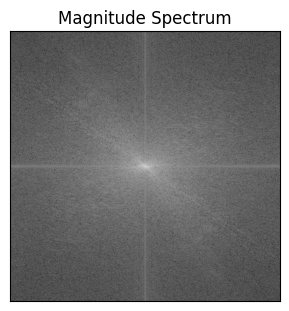

In [21]:
lena_gray_float = np.float32(lena_gray)

# 傅里叶变换
lena_dft = cv.dft(lena_gray_float, flags=cv.DFT_COMPLEX_OUTPUT)
lena_dft_shift = np.fft.fftshift(lena_dft)  # 中心化

# 计算幅值谱
magnitude_spectrum = 20 * np.log(cv.magnitude(lena_dft_shift[:, :, 0], lena_dft_shift[:, :, 1]))

# 显示幅值谱
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.xticks([]), plt.yticks([])

低通滤波器：去除噪声

In [22]:
# 低通滤波
def apply_low_pass_filter(image, cutoff_frequency):
    # 获取图像的高度和宽度
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # 创建一个与图像大小相同的掩码
    mask = np.zeros((rows, cols, 2), np.uint8)
    
    # 在中心区域创建一个圆形掩码
    r = int(cutoff_frequency)
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= r * r
    mask[mask_area] = 1
    
    # 进行傅里叶变换
    f_transform = cv.dft(image, flags=cv.DFT_COMPLEX_OUTPUT)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # 应用低通滤波器
    filtered_f_transform = f_transform_shifted * mask
    
    # 进行逆傅里叶变换
    filtered_f_transform_ishift = np.fft.ifftshift(filtered_f_transform)
    filtered_image = cv.idft(filtered_f_transform_ishift)
    filtered_image = cv.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])
    
    return filtered_image

高通滤波器：增强边缘

In [23]:
def apply_high_pass_filter(image, cutoff_frequency):
    # 获取图像的高度和宽度
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # 创建一个与图像大小相同的掩码
    mask = np.ones((rows, cols, 2), np.uint8)
    
    # 在中心区域创建一个圆形掩码
    r = int(cutoff_frequency)
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= r * r
    mask[mask_area] = 0
    
    # 进行傅里叶变换
    f_transform = cv.dft(image, flags=cv.DFT_COMPLEX_OUTPUT)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # 应用高通滤波器
    filtered_f_transform = f_transform_shifted * mask
    
    # 进行逆傅里叶变换
    filtered_f_transform_ishift = np.fft.ifftshift(filtered_f_transform)
    filtered_image = cv.idft(filtered_f_transform_ishift)
    filtered_image = cv.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])
    
    return filtered_image

带阻（陷波）滤波器：识别由特定的、局部化频域成分引起的空间图像效果

In [24]:
def apply_band_stop_filter(image, low_cutoff, high_cutoff):
    # 获取图像的高度和宽度
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # 创建一个与图像大小相同的掩码
    mask = np.ones((rows, cols, 2), np.uint8)
    
    # 在中心区域创建两个圆形掩码
    low_r = int(low_cutoff)
    high_r = int(high_cutoff)
    x, y = np.ogrid[:rows, :cols]
    low_mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= low_r * low_r
    high_mask_area = (x - crow) ** 2 + (y - ccol) ** 2 >= high_r * high_r
    mask[low_mask_area | high_mask_area] = 0
    
    # 进行傅里叶变换
    f_transform = cv.dft(image, flags=cv.DFT_COMPLEX_OUTPUT)
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # 应用带阻滤波器
    filtered_f_transform = f_transform_shifted * mask
    
    # 进行逆傅里叶变换
    filtered_f_transform_ishift = np.fft.ifftshift(filtered_f_transform)
    filtered_image = cv.idft(filtered_f_transform_ishift)
    filtered_image = cv.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])
    
    return filtered_image

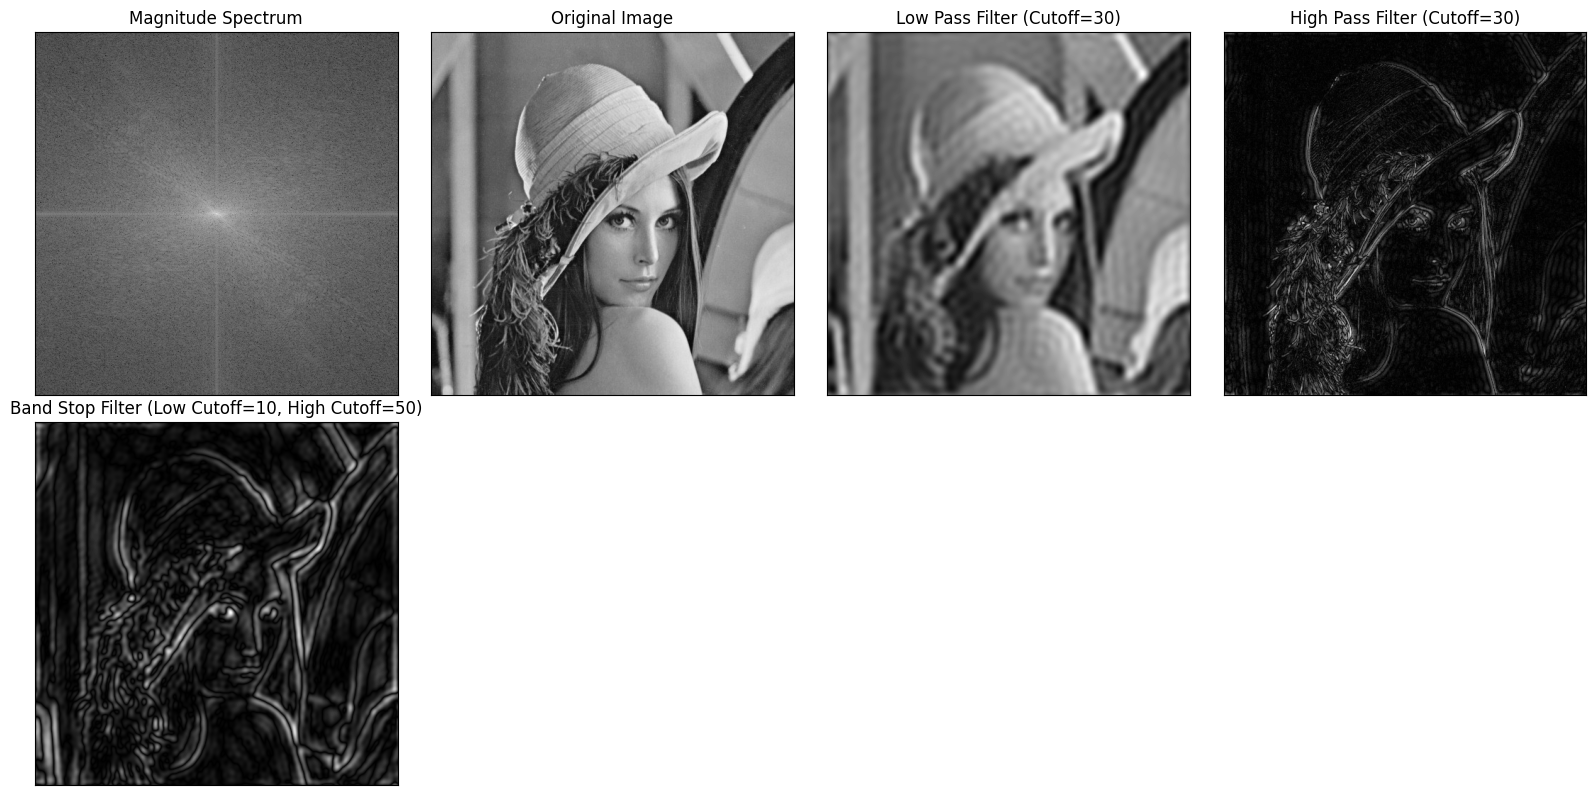

In [26]:
# 应用低通滤波器
cutoff_frequency_lp = 30
filtered_img_lp = apply_low_pass_filter(lena_gray_float, cutoff_frequency_lp)

# 应用高通滤波器
cutoff_frequency_hp = 30
filtered_img_hp = apply_high_pass_filter(lena_gray_float, cutoff_frequency_hp)

# 应用带阻滤波器
low_cutoff_bs = 10
high_cutoff_bs = 50
filtered_img_bs = apply_band_stop_filter(lena_gray_float, low_cutoff_bs, high_cutoff_bs)


# 显示幅值谱
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.xticks([]), plt.yticks([])

# 显示原始图像和处理后的图像
plt.subplot(2, 4, 2)
plt.imshow(lena_gray, cmap='gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 4, 3)
plt.imshow(filtered_img_lp, cmap='gray')
plt.title(f'Low Pass Filter (Cutoff={cutoff_frequency_lp})')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 4, 4)
plt.imshow(filtered_img_hp, cmap='gray')
plt.title(f'High Pass Filter (Cutoff={cutoff_frequency_hp})')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 4, 5)
plt.imshow(filtered_img_bs, cmap='gray')
plt.title(f'Band Stop Filter (Low Cutoff={low_cutoff_bs}, High Cutoff={high_cutoff_bs})')
plt.xticks([]), plt.yticks([])

# 调整子图之间的间距
plt.tight_layout()

# 显示所有图像
plt.show()

### 图像的几何变换

平移

In [ ]:
height, width = lena.shape[:2]

M = np.float32([[1, 0, 100], [0, 1, 50]]) # 平移矩阵, x方向平移100，y方向平移50
lena_translation = cv.warpAffine(lena, M, (width, height)) # 仿射变换
#show_img('Translation', np.hstack((lena, lena_translation)))

旋转

In [ ]:
height, width = lena.shape[:2]
M = cv.getRotationMatrix2D((height/2, width/2), 45, 0.5) # 旋转矩阵，旋转中心为图像中心，角度为逆时针45度，缩放因子为0.5
lena_rotation = cv.warpAffine(lena, M, (height, width)) # 仿射变换
#show_img('Rotation', np.hstack((lena, dst)))

错切

In [ ]:
height, width = lena.shape[:2]

shear_x_M = np.float32([[1, 0.25, 0], [0, 1, 0]]) # x方向错切矩阵
shear_y_M = np.float32([[1, 0, 0], [0.25, 1, 0]]) # y方向错切矩阵

lena_shear_x = cv.warpAffine(lena, shear_x_M, (width + int(0.25 * height), height)) # x方向错切, 宽度增加
lena_shear_y = cv.warpAffine(lena, shear_y_M, (width, height + int(0.25 * width))) # y方向错切, 高度增加

#show_img('Shear_x', np.hstack((lena, lena_shear_x)))
#show_img('Shear_y', lena_shear_y)

缩放

In [ ]:
height, width = lena.shape[:2]
scale_percent = 50 # 缩放比例
new_height = int(height * scale_percent / 100)
new_width = int(width * scale_percent / 100)
lena_resized = cv.resize(lena, (new_height, new_width), interpolation=cv.INTER_LINEAR) # 缩放
#show_img('Resized', lena_resized)


翻转

In [ ]:
# 水平镜像
lena_horizontal_flip = cv.flip(lena, 1)

# 垂直镜像
lena_vertical_flip = cv.flip(lena, 0)

# 水平和垂直镜像
lena_both_axes_flip = cv.flip(lena, -1)
#show_img('Flips', np.hstack((lena, lena_both_axes_flip)))

### 数字图像边缘检测

In [11]:
upper, lower = 70, 150
lena_gray_blurred_gaussian = cv.GaussianBlur(lena_gray, (5, 5), 0) # 高斯滤波，去噪
lena_gray_edges = cv.Canny(lena_gray_blurred_gaussian, upper, lower) # 边缘检测
show_img('Edges', np.hstack((lena_gray, lena_gray_edges)))

In [12]:
# Sobel边缘检测
def sobel_edge_detection(image):
    """使用Sobel算子进行边缘检测"""
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    grad_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3) # 求x方向梯度
    grad_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3) # 求y方向梯度
    gradient_magnitude = cv.magnitude(grad_x, grad_y) # 梯度幅值
    gradient_magnitude = cv.convertScaleAbs(gradient_magnitude)
    return gradient_magnitude

lena_edges_sobel = sobel_edge_detection(lena)
show_img('Sobel Edges', np.hstack((lena_gray, lena_edges_sobel)))

In [10]:
# Laplacian边缘检测
def laplacian_edge_detection(image):
    """使用Laplacian算子进行边缘检测"""
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return cv.Laplacian(image, cv.CV_64F)

lena_edges_laplacian = laplacian_edge_detection(lena)
show_img('Laplacian Edges', np.hstack((lena_gray, lena_edges_laplacian)))

### 数字图像轮廓提取

轮廓提取

In [ ]:
lena_gray_blurred_gaussian = cv.GaussianBlur(lena_gray, (5, 5), 0) # 高斯滤波，去噪

# 二值化
threshold = 100 # 阈值
_, th_fixed = cv.threshold(lena_gray_blurred_gaussian, threshold, 255, cv.THRESH_BINARY)

contours, hierarchy = cv.findContours(th_fixed, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) # 查找轮廓

# 绘制轮廓
lena_contours = lena.copy()
cv.drawContours(lena_contours, contours, -1, (0, 255, 0), 1)

#show_img('Contours', lena_contours)

轮廓特征

In [37]:
print('Number of contours:', len(contours))
# 遍历每个轮廓并提取特征
for i, contour in enumerate(contours):
    # 计算面积
    area = cv.contourArea(contour)
    
    # 计算周长
    perimeter = cv.arcLength(contour, True)
    
    # 计算矩形边界框
    x, y, w, h = cv.boundingRect(contour)
    bounding_rect = cv.rectangle(lena_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # 计算最小矩形边界框
    rect = cv.minAreaRect(contour) # 
    box = np.int32(cv.boxPoints(rect)) 
    
    # 计算圆形边界框
    (center_x, center_y), radius = cv.minEnclosingCircle(contour)
    center = (int(center_x), int(center_y))
    radius = int(radius)
    circle = cv.circle(lena_contours, center, radius, (0, 0, 255), 2)
    
    # 计算凸包
    hull = cv.convexHull(contour)
    convex_hull = cv.drawContours(lena_contours, [hull], -1, (0, 255, 255), 2)
    
    # 计算凹凸性缺陷
    if len(contour) > 3:
        hull_indices = cv.convexHull(contour, returnPoints=False)
        defects = cv.convexityDefects(contour, hull_indices)
        if defects is not None:
            for i in range(defects.shape[0]):
                s, e, f, d = defects[i, 0]
                start = tuple(contour[s][0])
                end = tuple(contour[e][0])
                far = tuple(contour[f][0])
                cv.line(lena_contours, start, end, [0, 255, 0], 2)
                cv.circle(lena_contours, far, 5, [0, 0, 255], -1)
    
    # 打印特征
    print('******************************************************')
    print(f"Contour {i}:")
    print(f"    Area: {area}")
    print(f"    Perimeter: {perimeter}")
    print(f"    Bounding Rectangle: ({x}, {y}, {w}, {h})")
    print(f"    Min Area Rectangle: {rect[0:2]}, Angel: {rect[2]}")
    print(f"    Min Enclosing Circle Center: {center}, Radius: {radius}")

Number of contours: 128
******************************************************
Contour 0:
    Area: 0.0
    Perimeter: 0.0
    Bounding Rectangle: (132, 511, 1, 1)
    Min Area Rectangle: ((132.0, 511.0), (0.0, 0.0)), Angel: 0.0
    Min Enclosing Circle Center: (132, 511), Radius: 0
******************************************************
Contour 1:
    Area: 0.0
    Perimeter: 4.0
    Bounding Rectangle: (139, 509, 1, 3)
    Min Area Rectangle: ((139.0, 510.0), (2.0, 0.0)), Angel: -90.0
    Min Enclosing Circle Center: (139, 510), Radius: 1
******************************************************
Contour 0:
    Area: 0.5
    Perimeter: 5.414213538169861
    Bounding Rectangle: (106, 509, 2, 3)
    Min Area Rectangle: ((106.5, 510.0), (2.0, 1.0)), Angel: 90.0
    Min Enclosing Circle Center: (106, 510), Radius: 1
******************************************************
Contour 5:
    Area: 225.5
    Perimeter: 95.35533845424652
    Bounding Rectangle: (402, 497, 34, 15)
    Min Area Rectangl

### 灰度图像几何形状检测

In [ ]:
def detect_shapes(image):
    # 将图像转换为灰度图像
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # 应用高斯模糊以减少噪声并改进轮廓检测
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    # 使用Canny边缘检测器检测边缘
    edges = cv.Canny(blurred, 50, 150)
    
    # 查找边缘图像中的轮廓
    contours, _ = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    shapes = []
    
    for contour in contours:
        shape = "unknown"
        # 计算轮廓的面积
        area = cv.contourArea(contour)
        # 跳过面积过小的轮廓
        if area < 10:
            continue

        epsilon = 0.02 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        
        # 根据顶点数量确定形状
        if len(approx) == 3:
            shape = "triangle" # 三角形
        elif len(approx) == 4:
            # 检查是否为正方形或矩形
            x, y, w, h = cv.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.95 <= aspect_ratio <= 1.05:
                shape = "square" # 正方形
            else:
                shape = "rectangle" # 矩形
        elif len(approx) == 5:
            shape = "pentagon" # 五边形
        elif len(approx) == 6:
            shape = "hexagon" # 六边形
        else:
            # 检查是否为圆形或椭圆
            perimeter = cv.arcLength(contour, True)
            circularity = 4 * np.pi * (area / (perimeter ** 2)) # 圆形度
        
            if circularity > 0.85:
                shape = "circle" # 圆形
            else:
                # 拟合椭圆并检查其偏心率
                ellipse = cv.fitEllipse(contour)
                major_axis = max(ellipse[1])
                minor_axis = min(ellipse[1])
                eccentricity = np.sqrt(1 - (minor_axis / major_axis) ** 2)
                
                if eccentricity < 0.1:
                    shape = "circle" # 圆形
                elif eccentricity < 0.9:
                    shape = "ellipse" # 椭圆
        
        # 在图像上绘制轮廓并在中心位置标注形状名称
        cv.drawContours(image, [contour], -1, (0, 255, 0), 2)
        M = cv.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv.putText(image, shape, (cX, cY), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        shapes.append(shape)
    
    return image, shapes

def geometric_dectect(image, sub_option):
    if sub_option == '轮廓检测':
        result_image = image.copy()
        result_image, detected_shapes = detect_shapes(result_image)
        print(f"检测到的形状: {detected_shapes}")
    return result_image 

# 示例调用
geometry = cv.imread('geometry.png')
result_image, detected_shapes = detect_shapes(geometry)
cv.imshow('Detected Shape', result_image)
cv.waitKey(0)
cv.destroyAllWindows()
print(f"检测到的形状: {detected_shapes}")

检测到的形状: ['rectangle', 'pentagon', 'triangle', 'square', 'hexagon', 'unknown', 'circle', 'triangle', 'rectangle', 'rectangle', 'square', 'triangle']


### 形态学图像处理

In [4]:
dog = cv.imread('dog.jpg')
get_attributes(dog)
dog_gray = cv.cvtColor(dog, cv.COLOR_BGR2GRAY)

Image shape: (512, 512, 3)
Image size: 786432
Image data type: uint8


In [5]:
ret, dog_thresh = cv.threshold(dog_gray, 150, 255, cv.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8) # 5x5的卷积核
dog_dilated = cv.dilate(dog_thresh, kernel, iterations=1) # 膨胀
dog_eroded = cv.erode(dog_thresh, kernel, iterations=1) # 腐蚀

kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5)) # 矩形结构元素
dog_opened = cv.morphologyEx(dog_thresh, cv.MORPH_OPEN, kernel) # 开运算
dog_closed = cv.morphologyEx(dog_thresh, cv.MORPH_CLOSE, kernel) # 闭运算

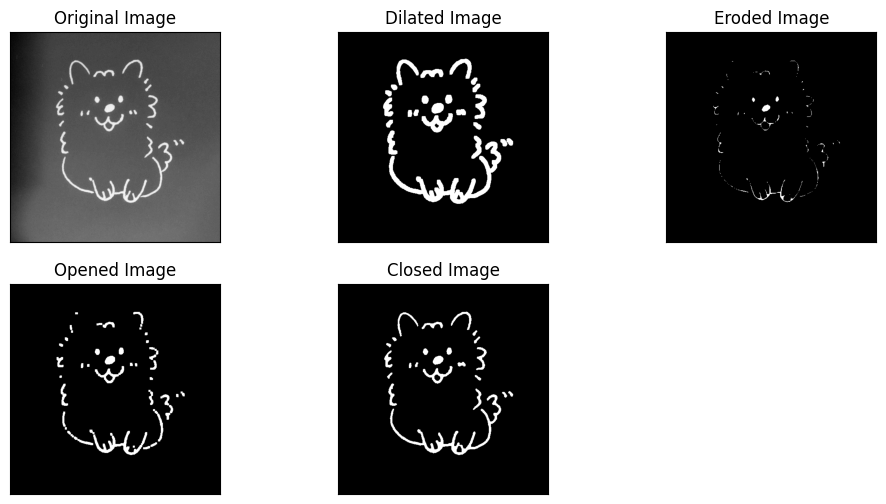

In [6]:
# plt展示原灰度图，膨胀，腐蚀和开运算，闭运算
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(dog_gray, cmap='gray')
plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 3, 2)
plt.imshow(dog_dilated, cmap='gray')
plt.title('Dilated Image')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 3, 3)
plt.imshow(dog_eroded, cmap='gray')
plt.title('Eroded Image')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 3, 4)
plt.imshow(dog_opened, cmap='gray')
plt.title('Opened Image')
plt.xticks([]), plt.yticks([])

plt.subplot(2, 3, 5)
plt.imshow(dog_closed, cmap='gray')
plt.title('Closed Image')
plt.xticks([]), plt.yticks([])
plt.show()


In [7]:
gradient = cv.morphologyEx(dog_thresh, cv.MORPH_GRADIENT, kernel) # 梯度
tophat = cv.morphologyEx(dog_thresh, cv.MORPH_TOPHAT, kernel) # 顶帽
blackhat = cv.morphologyEx(dog_thresh, cv.MORPH_BLACKHAT, kernel) # 黑帽